# Comparing the Efficacy of the Exemplar and Prototype Models for Predicting Color Categorization Across Languages

COG260 Research Project 2023

Gabriel Guralnick and Elizabeth Li

## Demos for analyzing World Color Survey (WCS)

COG 260: Data, Computation, and The Mind (Yang Xu)

Data source: http://www1.icsi.berkeley.edu/wcs/data.html

______________________________________________

Import helper function file for WCS data analysis.

In [230]:
from wcs_helper_functions import *

Import relevant Python libraries.

In [231]:
import numpy as np
from scipy import stats
from random import random
from collections import defaultdict, Counter
%matplotlib inline

### Demo 1: Import stimulus (color chip) information in [Munsell space](https://en.wikipedia.org/wiki/Munsell_color_system)

> Stimuli were 330 color chips in Munsell space, each defined along lightness and hue dimensions.

> Each color chip has an index _(from 1 to 330)_ and a coordinate (lightness *(alphabet)*, hue *(integer)*).

In the following section, you will learn how to convert from **(a) index to coordinate** and **(b) coordinate to index**.

______________________________________________

Load chip information in Munsell space. 

`munsellInfo` is a 2-element tuple with dictionary elements.

In [232]:
munsellInfo = readChipData('./WCS_data_core/chip.txt')
munsellInfo

({'E29': 1,
  'C23': 2,
  'F4': 3,
  'I36': 4,
  'C20': 5,
  'C6': 6,
  'E15': 7,
  'H40': 8,
  'G6': 9,
  'I30': 10,
  'I22': 11,
  'C11': 12,
  'I18': 13,
  'I26': 14,
  'C35': 15,
  'C0': 16,
  'E3': 17,
  'I11': 18,
  'E27': 19,
  'F16': 20,
  'E39': 21,
  'B10': 22,
  'F34': 23,
  'H10': 24,
  'G24': 25,
  'H30': 26,
  'B5': 27,
  'E38': 28,
  'D18': 29,
  'F6': 30,
  'C24': 31,
  'E36': 32,
  'D15': 33,
  'F28': 34,
  'D3': 35,
  'I20': 36,
  'E30': 37,
  'G39': 38,
  'G16': 39,
  'E25': 40,
  'H3': 41,
  'E10': 42,
  'I29': 43,
  'B40': 44,
  'E17': 45,
  'F0': 46,
  'I17': 47,
  'E8': 48,
  'D25': 49,
  'I35': 50,
  'H8': 51,
  'B16': 52,
  'H39': 53,
  'G15': 54,
  'E24': 55,
  'C4': 56,
  'H24': 57,
  'F10': 58,
  'C34': 59,
  'I25': 60,
  'H2': 61,
  'E32': 62,
  'D1': 63,
  'G29': 64,
  'F39': 65,
  'B8': 66,
  'C18': 67,
  'E37': 68,
  'G12': 69,
  'C32': 70,
  'I1': 71,
  'G19': 72,
  'H34': 73,
  'C26': 74,
  'I16': 75,
  'F5': 76,
  'F24': 77,
  'C36': 78,
  'H0': 79,
 

#### (a) Index &rarr; Coordinate

Access the second dictionary in `munsellInfo`.

In [233]:
indexCoord = munsellInfo[1]

`indexCoord` is a dictionary with **index _(key)_ &rarr; coordinate _(value)_** pairs. For example, to retrieve the Munsell coordinate _(lightness, hue)_ for chip with numerical index 1:

In [234]:
print(indexCoord[1])

('E', '29')


You can also uncomment the following to display full stimulus information (long).

In [235]:
# print(indexCoord)

#### (b) Coordinate &rarr; Index

Access the first dictionary in `munsellInfo`.

In [236]:
coordIndex = munsellInfo[0]

`coordIndex` is a dictionary with **coordinate _(key)_ &rarr; index _(value)_** pairs. For example, to access numerical index for the color chip at Munsell coordinate _(D, 11)_:

In [237]:
print(coordIndex['D11'])

258


You can also uncomment the following to display full stimulus information (long).

In [238]:
# print(coordIndex)

### Demo 2: Import stimulus information in [CIELAB space](https://en.wikipedia.org/wiki/Lab_color_space)

> Each of the 330 stimuli can also be mapped to the 3D CIELAB space, where the dimensions are `l` _(lightness)_, `a`, & `b` _(color opponency)_.

> CIELAB Coordinates have a **one-to-one** correspondence with Munsell index, which ranges from 1 to 330.

______________________________________________

Load chip coordinates in CIELAB. 

`cielabCoord` is a dictionary with **index _(key)_ &rarr; CIELAB Coordinate _(value)_** pairs.

In [239]:
cielabCoord = readClabData('./WCS_data_core/cnum-vhcm-lab-new.txt')

For example, to obtain the CIELAB coordinates for chip with numerical index 1:

In [240]:
print(cielabCoord[1])

('61.70', '-4.52', '-39.18')


### Demo 3: Import color naming data
    
> Each of the 330 color chips was named by speakers of 110 different languages.

______________________________________________

Load naming data. 

`namingData` is a hierarchical dictionary organized as follows:

**language _(1 - 110)_ &rarr; speaker _(1 - *range varies per language*)_ &rarr; chip index _(1 - 330)_ &rarr; color term**

In [241]:
namingData = readNamingData('./WCS_data_core/term.txt')

For example, to obtain naming data from language 1 and speaker 1 for all 330 color chips:

In [242]:
namingData[1][1]; # remove semicolon to see data in full

For example, to see how many speakers language 1 has:

In [243]:
len(namingData[1])

25

### Demo 4: Import color foci data
    
> Apart from naming the color chips, each speaker also pointed to foci color chips for each color term they had used.

> **Note**: A single color term may have multiple foci locations.

______________________________________________

Load foci data. 

`fociData` is a hierarchical dictionary organized as follows: 

**language _(1 - 110)_ &rarr; speaker _(1 - *range varies per language*)_ &rarr; color term &rarr; foci coordinates**

In [244]:
fociData = readFociData('./WCS_data_core/foci-exp.txt');

For example, to obtain foci data for language 1 and speaker 1, where each entry shows foci locations for given term: 

In [245]:
fociData[1][1]

{'LF': ['A:0'],
 'WK': ['D:9', 'D:10', 'D:11', 'D:12'],
 'F': ['D:25'],
 'LB': ['J:0'],
 'G': ['F:17'],
 'LE': ['F:1', 'F:2', 'F:3', 'G:1', 'G:2', 'G:3']}

In the above example, foci for term 'LF' is located at coordinate _(A, 0)_ in the Munsell chart.

### Demo 5: Import speaker demographic information

> Most speakers' age _(integer)_ and gender _(M/F)_ information was recorded.

______________________________________________

Load speaker information.

`speakerInfo` is a hierarchical dictionary organized as follows:

**language &rarr; speaker &rarr; (age, gender)**

In [246]:
speakerInfo = readSpeakerData('./WCS_data_core/spkr-lsas.txt')

For example, uncomment the following line to access _(age, gender)_ information for all speakers from language 1:

In [247]:
# speakerInfo[1]

For example, uncomment the following line to access _(age, gender)_ information for speaker 1 from language 1:

In [248]:
# speakerInfo[1][1]

### Demo 6: Visualize color naming from an individual speaker

> Naming patterns from a speaker can be visualized in the stimulus palette _(Munsell space)_.

______________________________________________

Extract an example speaker datum from an example language.

In [249]:
lg61_spk5 = namingData[61][5]

Extract color terms used by that speaker.

In [250]:
terms = lg61_spk5.values()
# terms

Encode the color terms into random numbers (for plotting purposes).

In [251]:
encoded_terms = map_array_to(terms, generate_random_values(terms))

Visualize the color naming pattern for that speaker&mdash;each color patch corresponds to extension of a color term. Color scheme is randomized, but the partition of the color space is invariant.

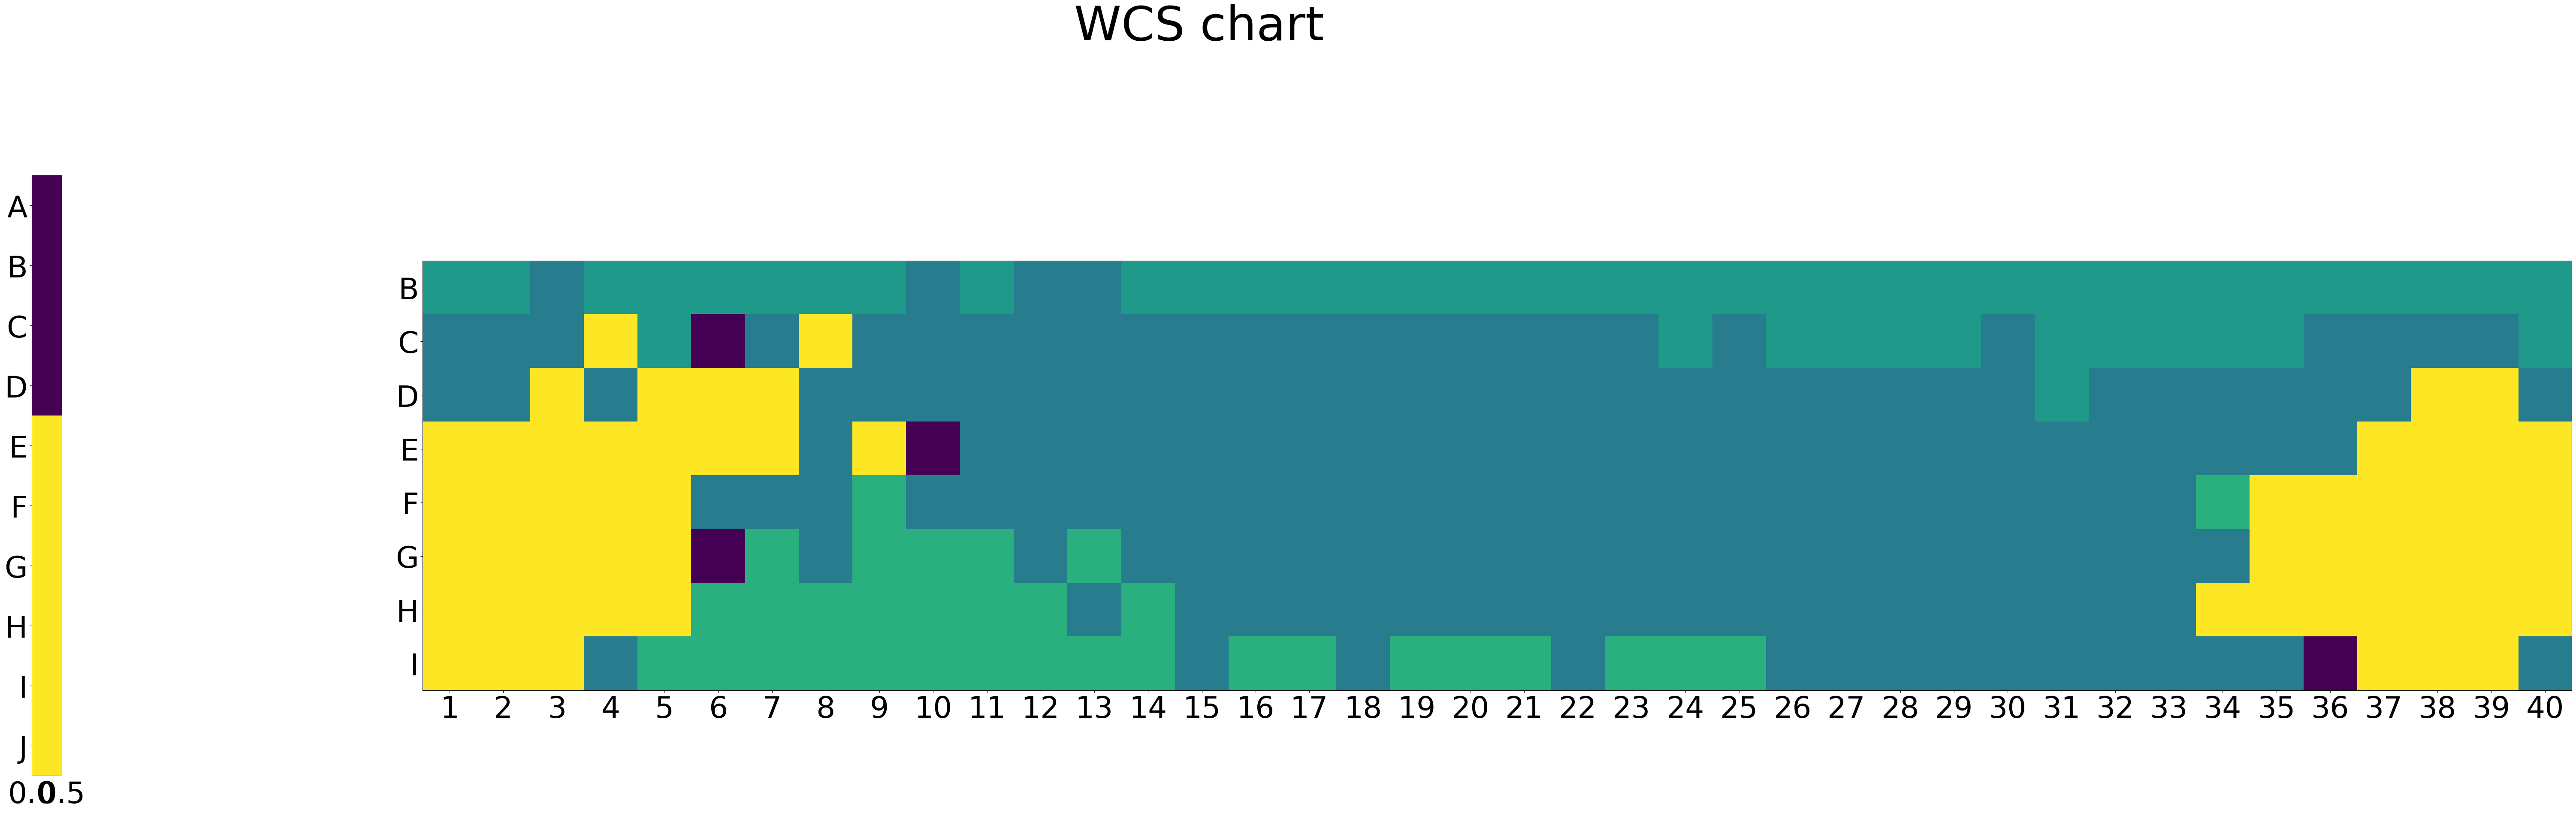

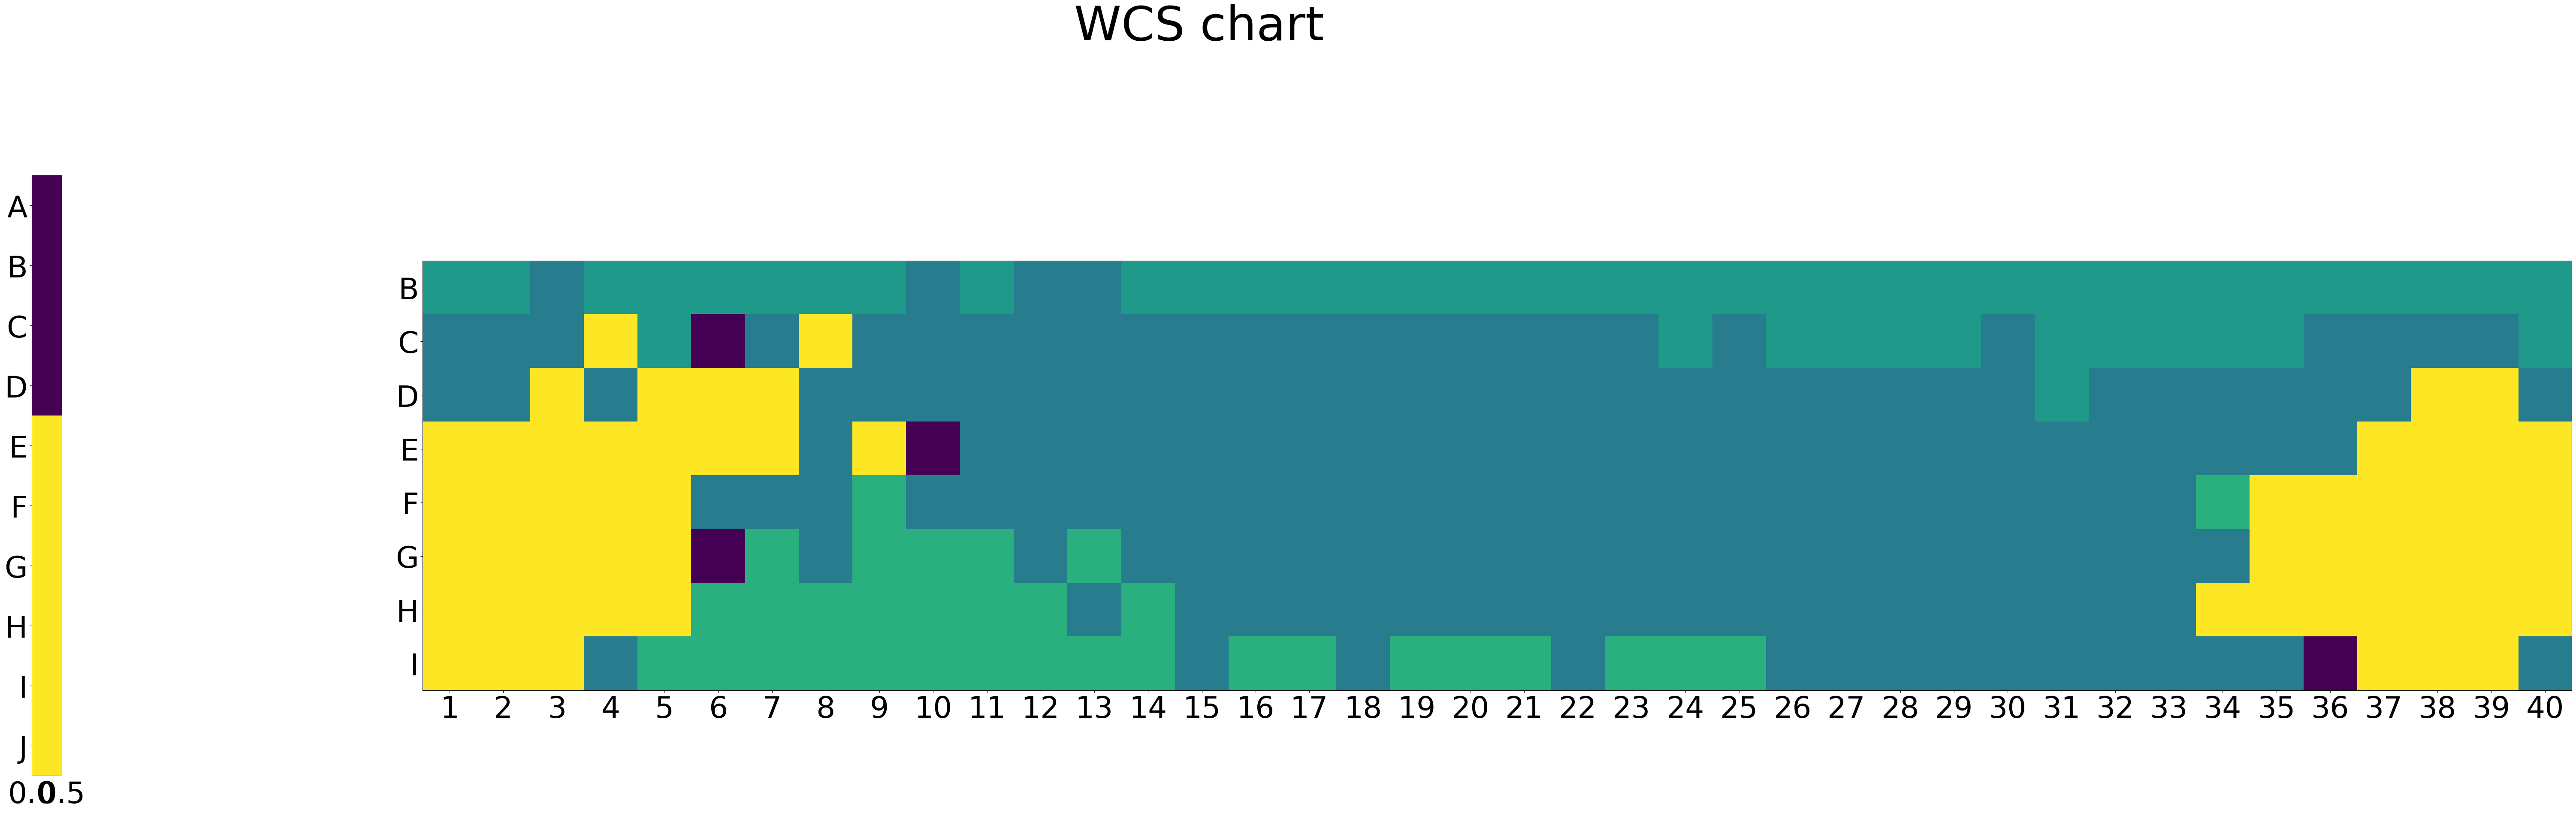

In [252]:
plotValues(encoded_terms)

**Note**: `plotValues()` is a generic function for visualizing various kinds of information on the chart, suited to needs.

Now you are in a position to start exploring this data set - enjoy!

## Our Analysis

### Qualitative Analysis - Foci Contour Plots

#### Empirical Color Foci

Our first goal is to reproduce the following diagram from Abbott, Griffiths, & Regier (2016) showing the empirical color foci from the WCS dataset.

![image.png](images/empirical-contours.png)

This graph shows the color chips that were most commonly identified as the focus of some color term across all languages. The clustering of the contours suggests a set of universal basic colors at each of the peaks in the contour plot.

Part of our evaluation of the prototype and exemplar models will be a qualitative comparison of their predicted color foci plots to this empirical one.

In [253]:
# fociData

In [254]:
overallFociCount = {}
for language in fociData:
    speakerData = fociData[language]
    for speaker in speakerData:
        colors = speakerData[speaker]
        for color in colors:
            colorFoci = colors[color]
            for focus in colorFoci:
                focusIndex = coordIndex[focus.replace(':', '')]
                if focusIndex in overallFociCount:
                    overallFociCount[focusIndex] += 1
                else:
                    overallFociCount[focusIndex] = 1


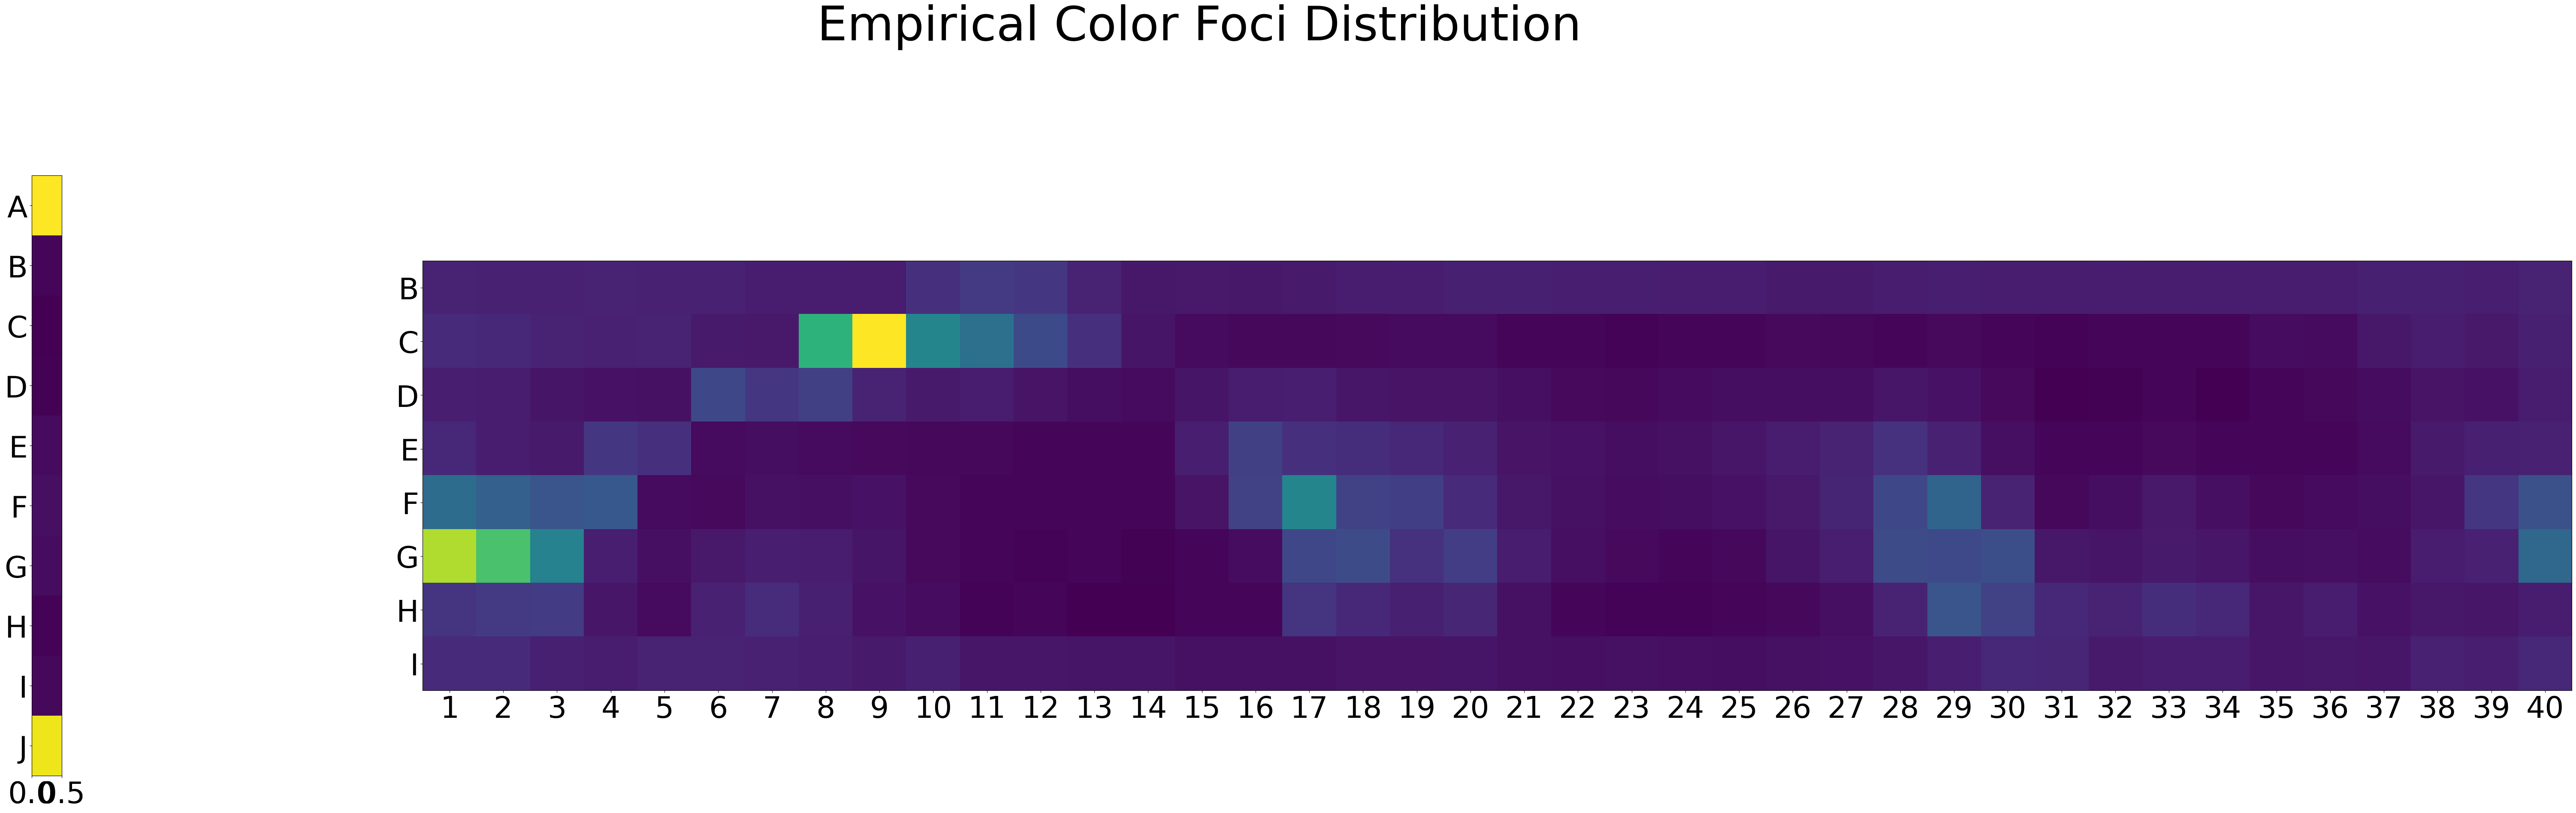

In [255]:
fig = plotValues(map_array_to(indexCoord, overallFociCount), title='Empirical Color Foci Distribution')

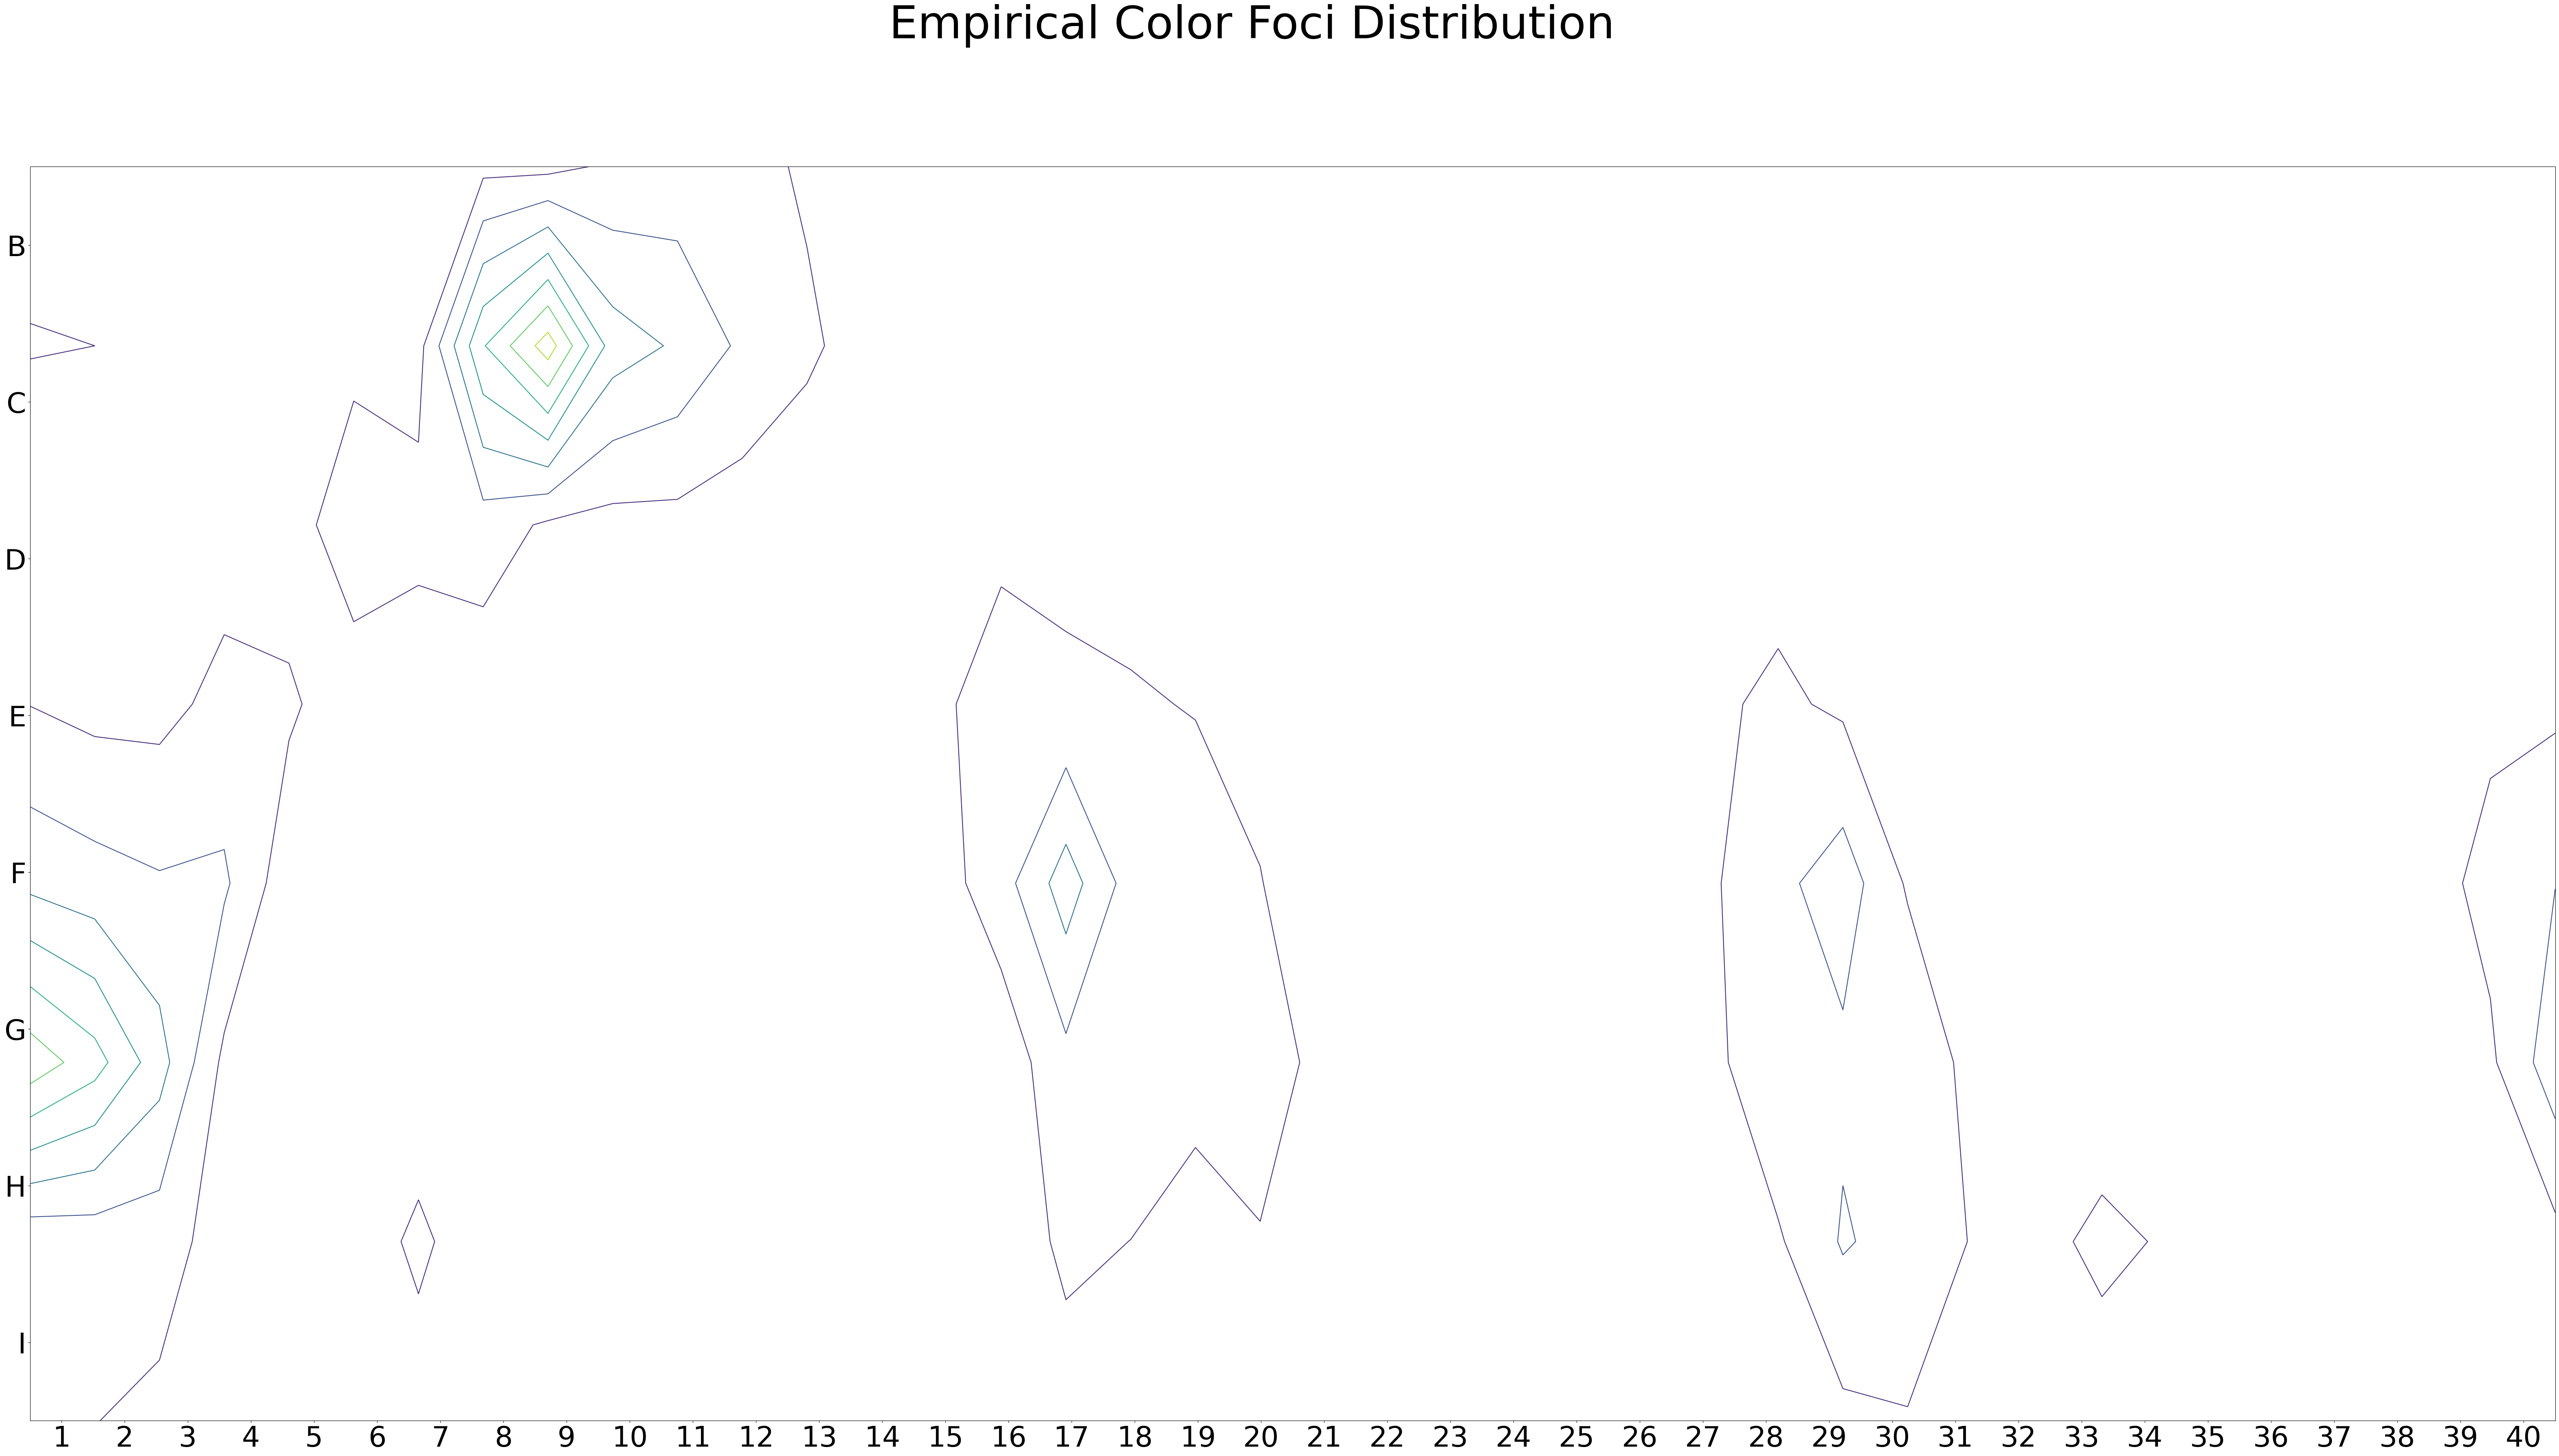

In [256]:
fig = plotValuesContour(map_array_to(indexCoord, overallFociCount), title='Empirical Color Foci Distribution')

#### Prototype Model

![image.png](images/prototype-contours.png)

In [301]:
# for each speaker and language, map color term -> chip
# format: (language, speaker) -> color term -> chip (array of values)
speaker_terms = {}

for language in namingData:
    # speaker_terms[language] = {}
    for speaker in namingData[language]:
        # speaker_terms[language][speaker] = {}
        speaker_terms[(language, speaker)] = {}
        for chip in namingData[language][speaker]:
            term = namingData[language][speaker][chip]
            if term not in speaker_terms[(language, speaker)]:
                speaker_terms[(language, speaker)][term] = []
            speaker_terms[(language, speaker)][term].append(chip)

# print(speaker_terms[(1, 1)])

{'LB': [1, 2, 10, 11, 13, 14, 18, 20, 24, 25, 26, 27, 30, 34, 35, 37, 38, 40, 41, 44, 46, 48, 50, 54, 55, 57, 60, 64, 75, 77, 80, 82, 85, 87, 89, 90, 93, 94, 97, 109, 111, 113, 114, 117, 122, 123, 127, 130, 133, 136, 140, 156, 163, 166, 168, 169, 170, 178, 188, 191, 198, 202, 209, 211, 216, 223, 226, 228, 235, 246, 253, 257, 271, 277, 279, 289, 291, 311], 'LE': [3, 6, 8, 9, 17, 21, 29, 31, 33, 36, 39, 42, 49, 53, 56, 61, 63, 65, 68, 76, 84, 86, 88, 96, 98, 101, 105, 106, 110, 112, 115, 118, 121, 125, 126, 131, 132, 135, 146, 148, 150, 151, 152, 159, 160, 162, 173, 174, 176, 187, 190, 201, 203, 207, 208, 212, 215, 217, 231, 237, 239, 245, 256, 259, 261, 266, 269, 270, 276, 278, 285, 288, 292, 297, 298, 317, 318, 321], 'WK': [4, 171, 179, 181, 183, 185, 193, 197, 204, 233, 240, 250, 251, 255, 268, 275, 283, 287, 295, 305, 320, 325, 326, 329], 'LF': [5, 15, 16, 19, 22, 23, 28, 32, 45, 47, 52, 59, 66, 70, 74, 78, 83, 92, 95, 99, 100, 102, 107, 108, 116, 120, 129, 138, 139, 141, 142, 158, 1

In [305]:
# now get the centroid of each color term for each language + speaker
# format: (language, speaker) -> color term -> CIELAB prototype coords
speaker_prototype = {}
for lang_speak in speaker_terms:
    speaker_prototype[lang_speak] = {}
    for color_term in speaker_terms[lang_speak]:
        chips = speaker_terms[lang_speak][color_term]
        # for each chip, get their cielab coordinates
        coords = np.array([tuple(map(float, cielabCoord[chip])) for chip in chips])
        # calculate centroid
        centroid = np.mean(coords, axis=0)
        speaker_prototype[lang_speak][color_term] = centroid

In [308]:
def compute_similarity(target, category_chips, c=0.001):
    # Vectorized computation of Euclidean distance between target and all CIELAB coordinates
    distances = np.linalg.norm(category_chips - target, axis=1)

    # Calculate the similarity scores
    similarities = np.exp(-c * distances**2)

    return similarities

cielab_array = np.array([tuple(map(float, coords)) for coords in cielabCoord.values()])

In [309]:
# now for each colour term, we'll try to predict foci coordinates (essentially recreating fociData)
predicted_prototype = {}
for language in fociData:
    for speaker in fociData[language]:
        if (language, speaker) not in speaker_prototype:
            continue
        for color_term in fociData[language][speaker]:
            if color_term not in speaker_prototype[(language, speaker)]:
                continue
            n = len(fociData[language][speaker][color_term])
            # predict foci coordinate -- compare speaker's prototype of this color term w/ CIELAB coords to get
            # the chip that's closest to the prototype
            prototype = np.array(speaker_prototype[(language, speaker)][color_term])

            # compute similarity of prototype w/ all cielab coords to get coord closest to prototype
            similarities = compute_similarity(prototype, cielab_array)

            chip_num_with_sim = list(zip(cielabCoord.keys(), similarities))
            chip_num_with_sim.sort(key=lambda x: x[1], reverse=True)

            # Get indices of the top n most similar chips
            # more similar = larger score
            top_n_indices = [chip_num_with_sim[i][0] for i in range(n)]

            # Update the predicted count for each of the top n chips
            for idx in top_n_indices:
                if idx not in predicted_prototype:
                    predicted_prototype[idx] = 0
                predicted_prototype[idx] += 1
            

In [312]:
print(len(predicted_prototype))
print(sum(overallFociCount.values()), sum(predicted_prototype.values()))

330
30991 29358


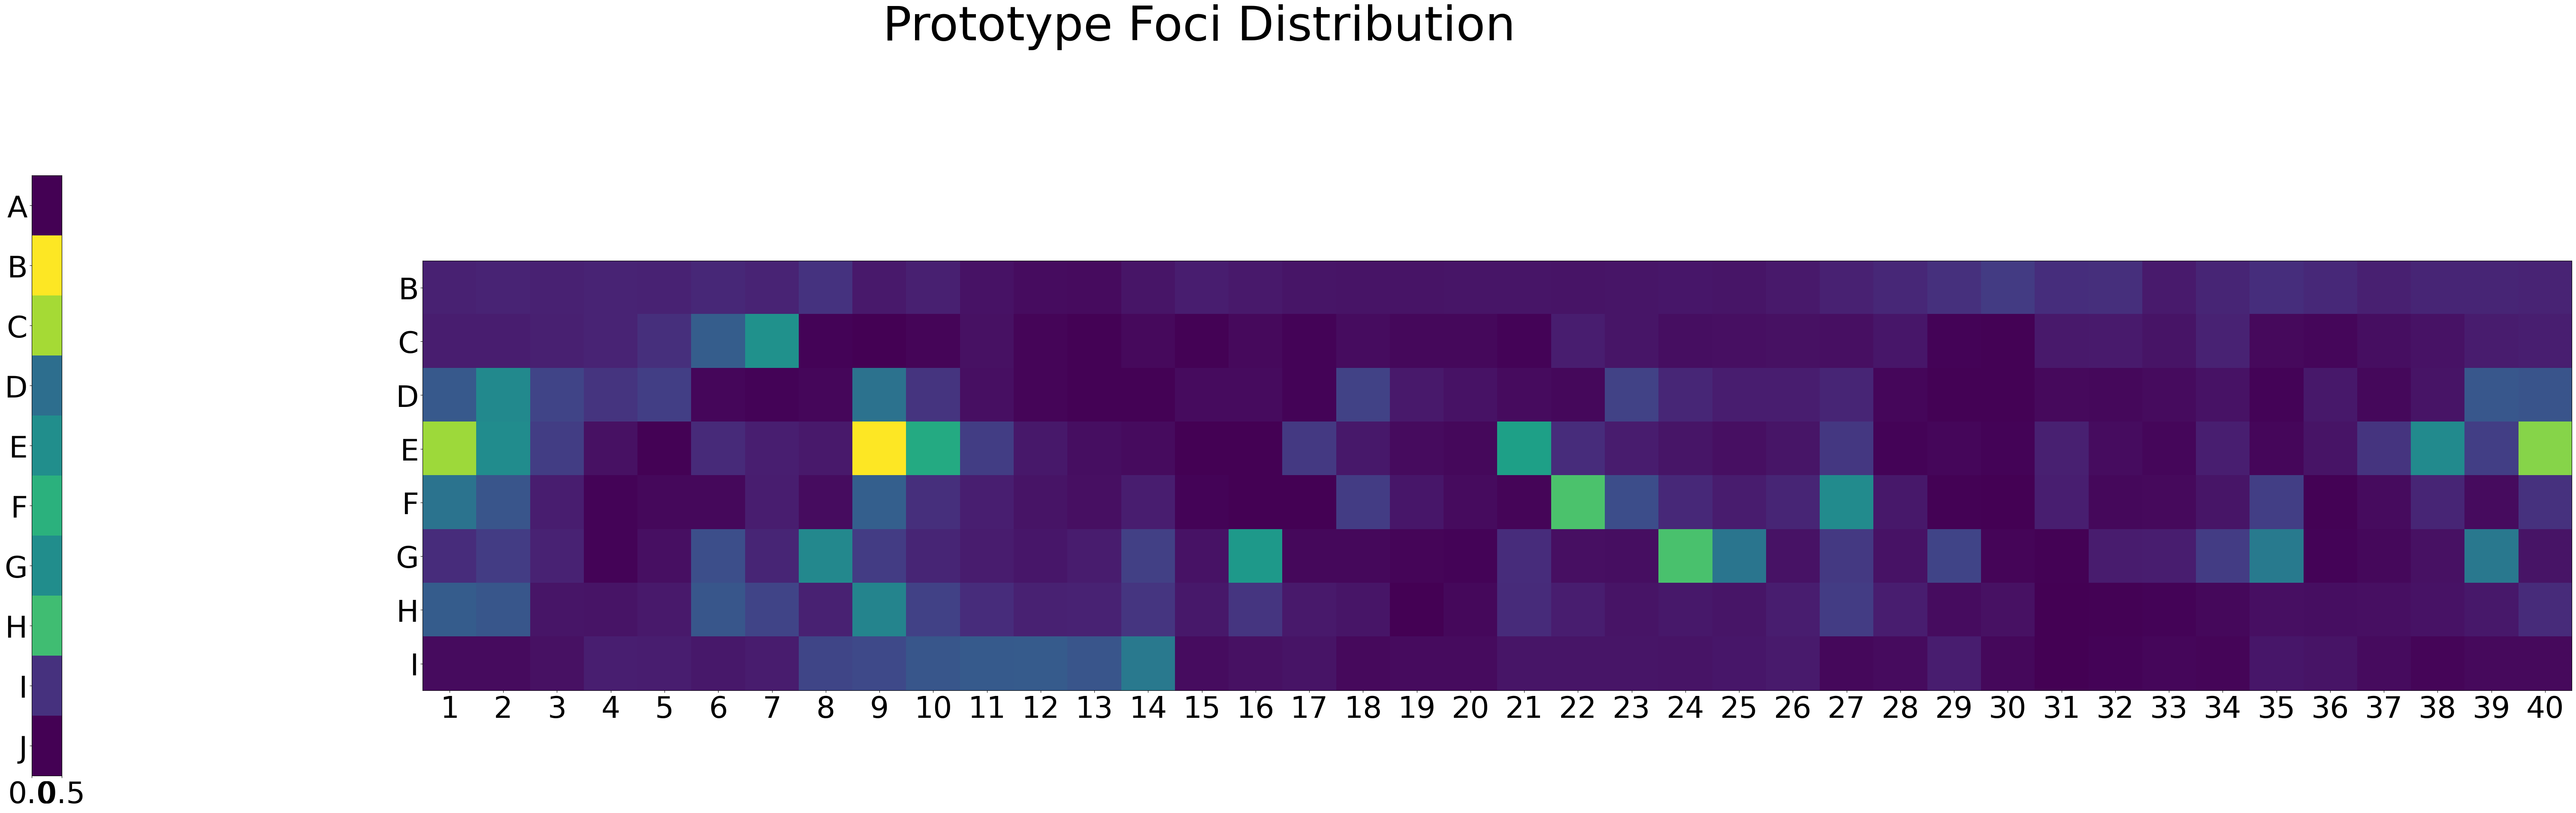

In [317]:
fig = plotValues(map_array_to(indexCoord, predicted_prototype), title='Prototype Foci Distribution')

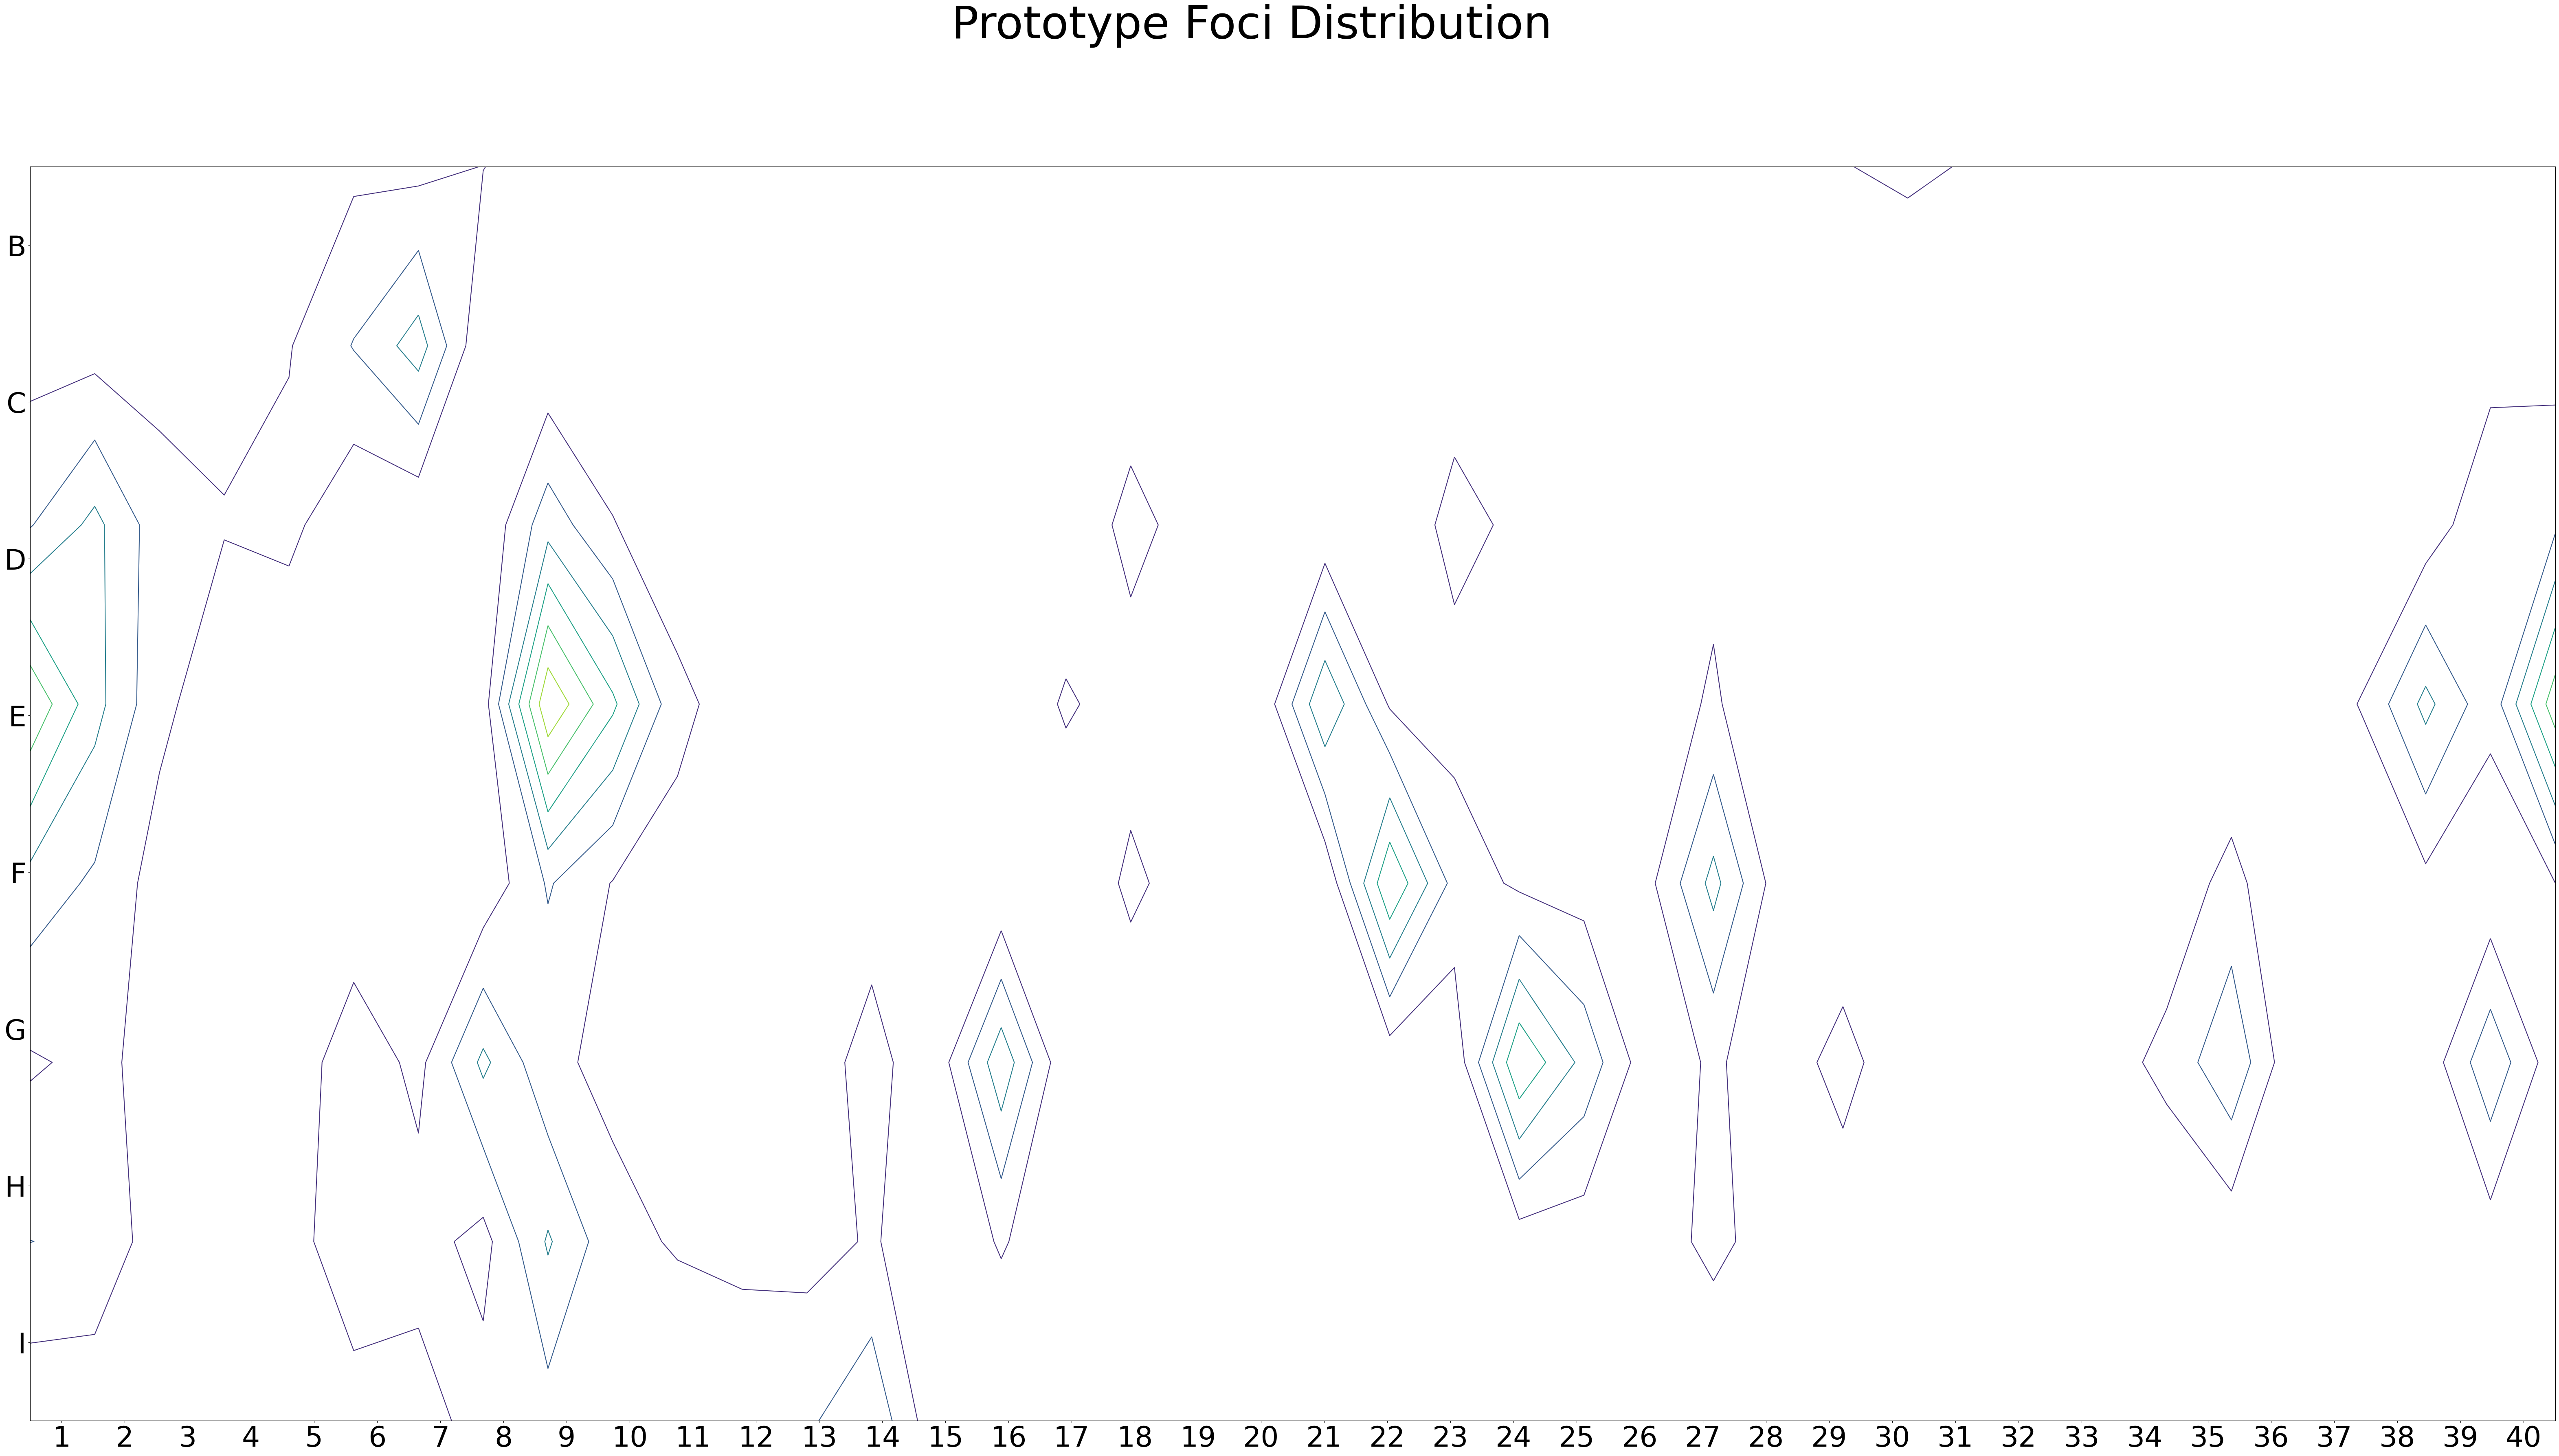

In [318]:
fig = plotValuesContour(map_array_to(indexCoord, predicted_prototype), title='Prototype Foci Distribution')

#### Exemplar Model

In [313]:
chipsByColor = {}
for language in namingData:
    if not language in chipsByColor:
        chipsByColor[language] = {}
    speakerData = namingData[language]
    for speaker in speakerData:
        if not speaker in chipsByColor[language]:
            chipsByColor[language][speaker] = {}
        chips = speakerData[speaker]
        for chip in chips:
            colorTerm = chips[chip]
            if not colorTerm in chipsByColor[language][speaker]:
                chipsByColor[language][speaker][colorTerm] = []
            chipsByColor[language][speaker][colorTerm].append(chip)

# chipsByColor

In [314]:
def sort_by_exemplar_score(all_chips_cielab, category_chips_cielab):
    """Sort all chips based on their exemplar scores for the category."""

    chip_num_with_score = []
    for i, chip in enumerate(all_chips_cielab):
        exemplar_score = np.sum(compute_similarity(chip, category_chips_cielab))
        chip_num_with_score.append((i + 1, exemplar_score))
    
    chip_num_with_score.sort(key=lambda x: x[1], reverse=True)

    return chip_num_with_score


In [315]:
exemplar_predicted = {}
for language in fociData:
    languageData = fociData[language]
    for speaker in languageData:
        if speaker not in chipsByColor[language]:
            continue
        speakerData = languageData[speaker]
        for colour in speakerData:
            fociInfo = speakerData[colour]
            n = len(fociInfo)

            if colour not in chipsByColor[language][speaker]:
                continue
            categoryChips = chipsByColor[language][speaker][colour]

            # Get the CIELAB coordinates for all chips in the category
            category_chips_cielab = np.array([tuple(map(float, cielabCoord[chip])) for chip in categoryChips])

            # Sort all chips based on their exemplar scores for the category
            sorted_chips = sort_by_exemplar_score(cielab_array, category_chips_cielab)

            top_n_indices = [sorted_chips[i][0] for i in range(n)]

            # Update the predicted count for each of the top n chips
            for idx in top_n_indices:
                if idx not in exemplar_predicted:
                    exemplar_predicted[idx] = 0
                exemplar_predicted[idx] += 1

In [316]:
# sanity check to see if the same number of predictions are made as the number of foci in the empirical data
print(len(overallFociCount), len(exemplar_predicted))
print(sum(overallFociCount.values()), sum(exemplar_predicted.values()))


330 330
30991 29358


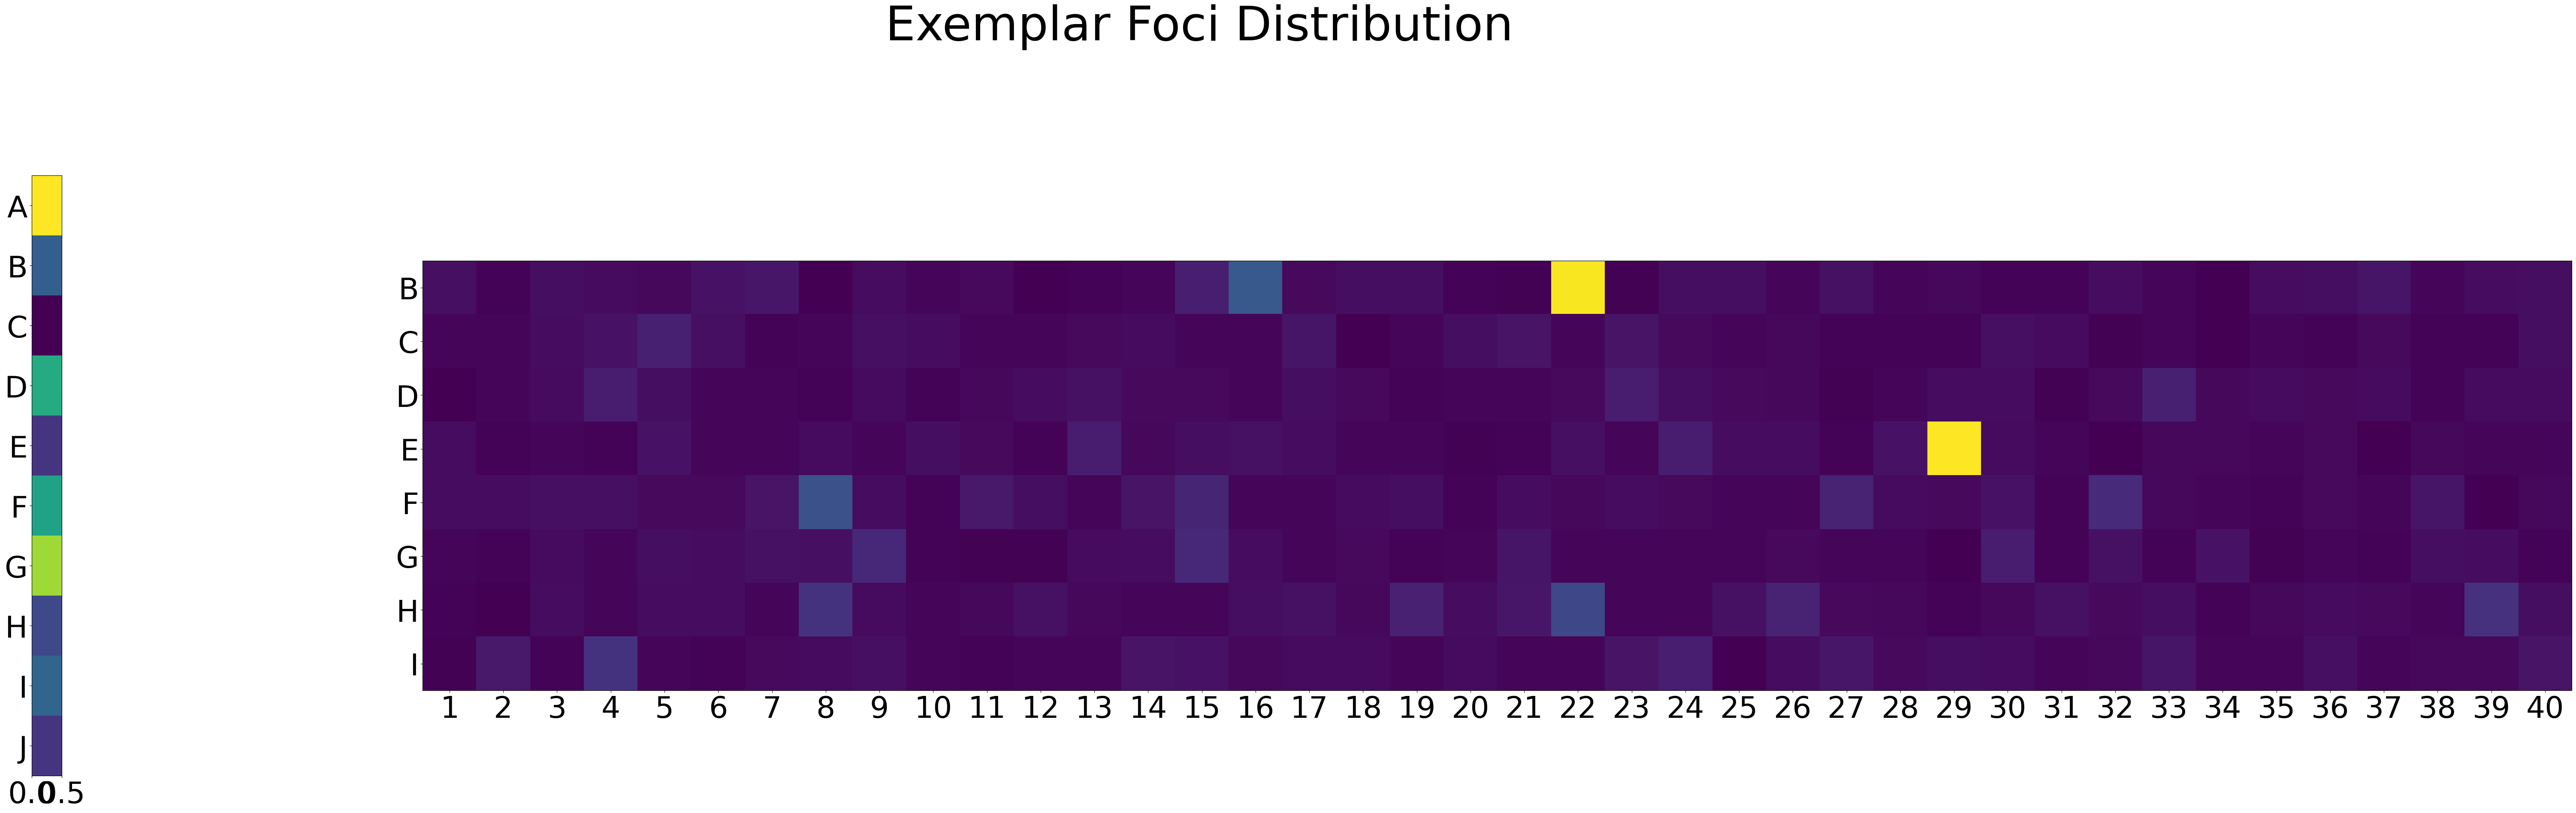

In [285]:
fig = plotValues(map_array_to(indexCoord, exemplar_predicted), title='Exemplar Foci Distribution')

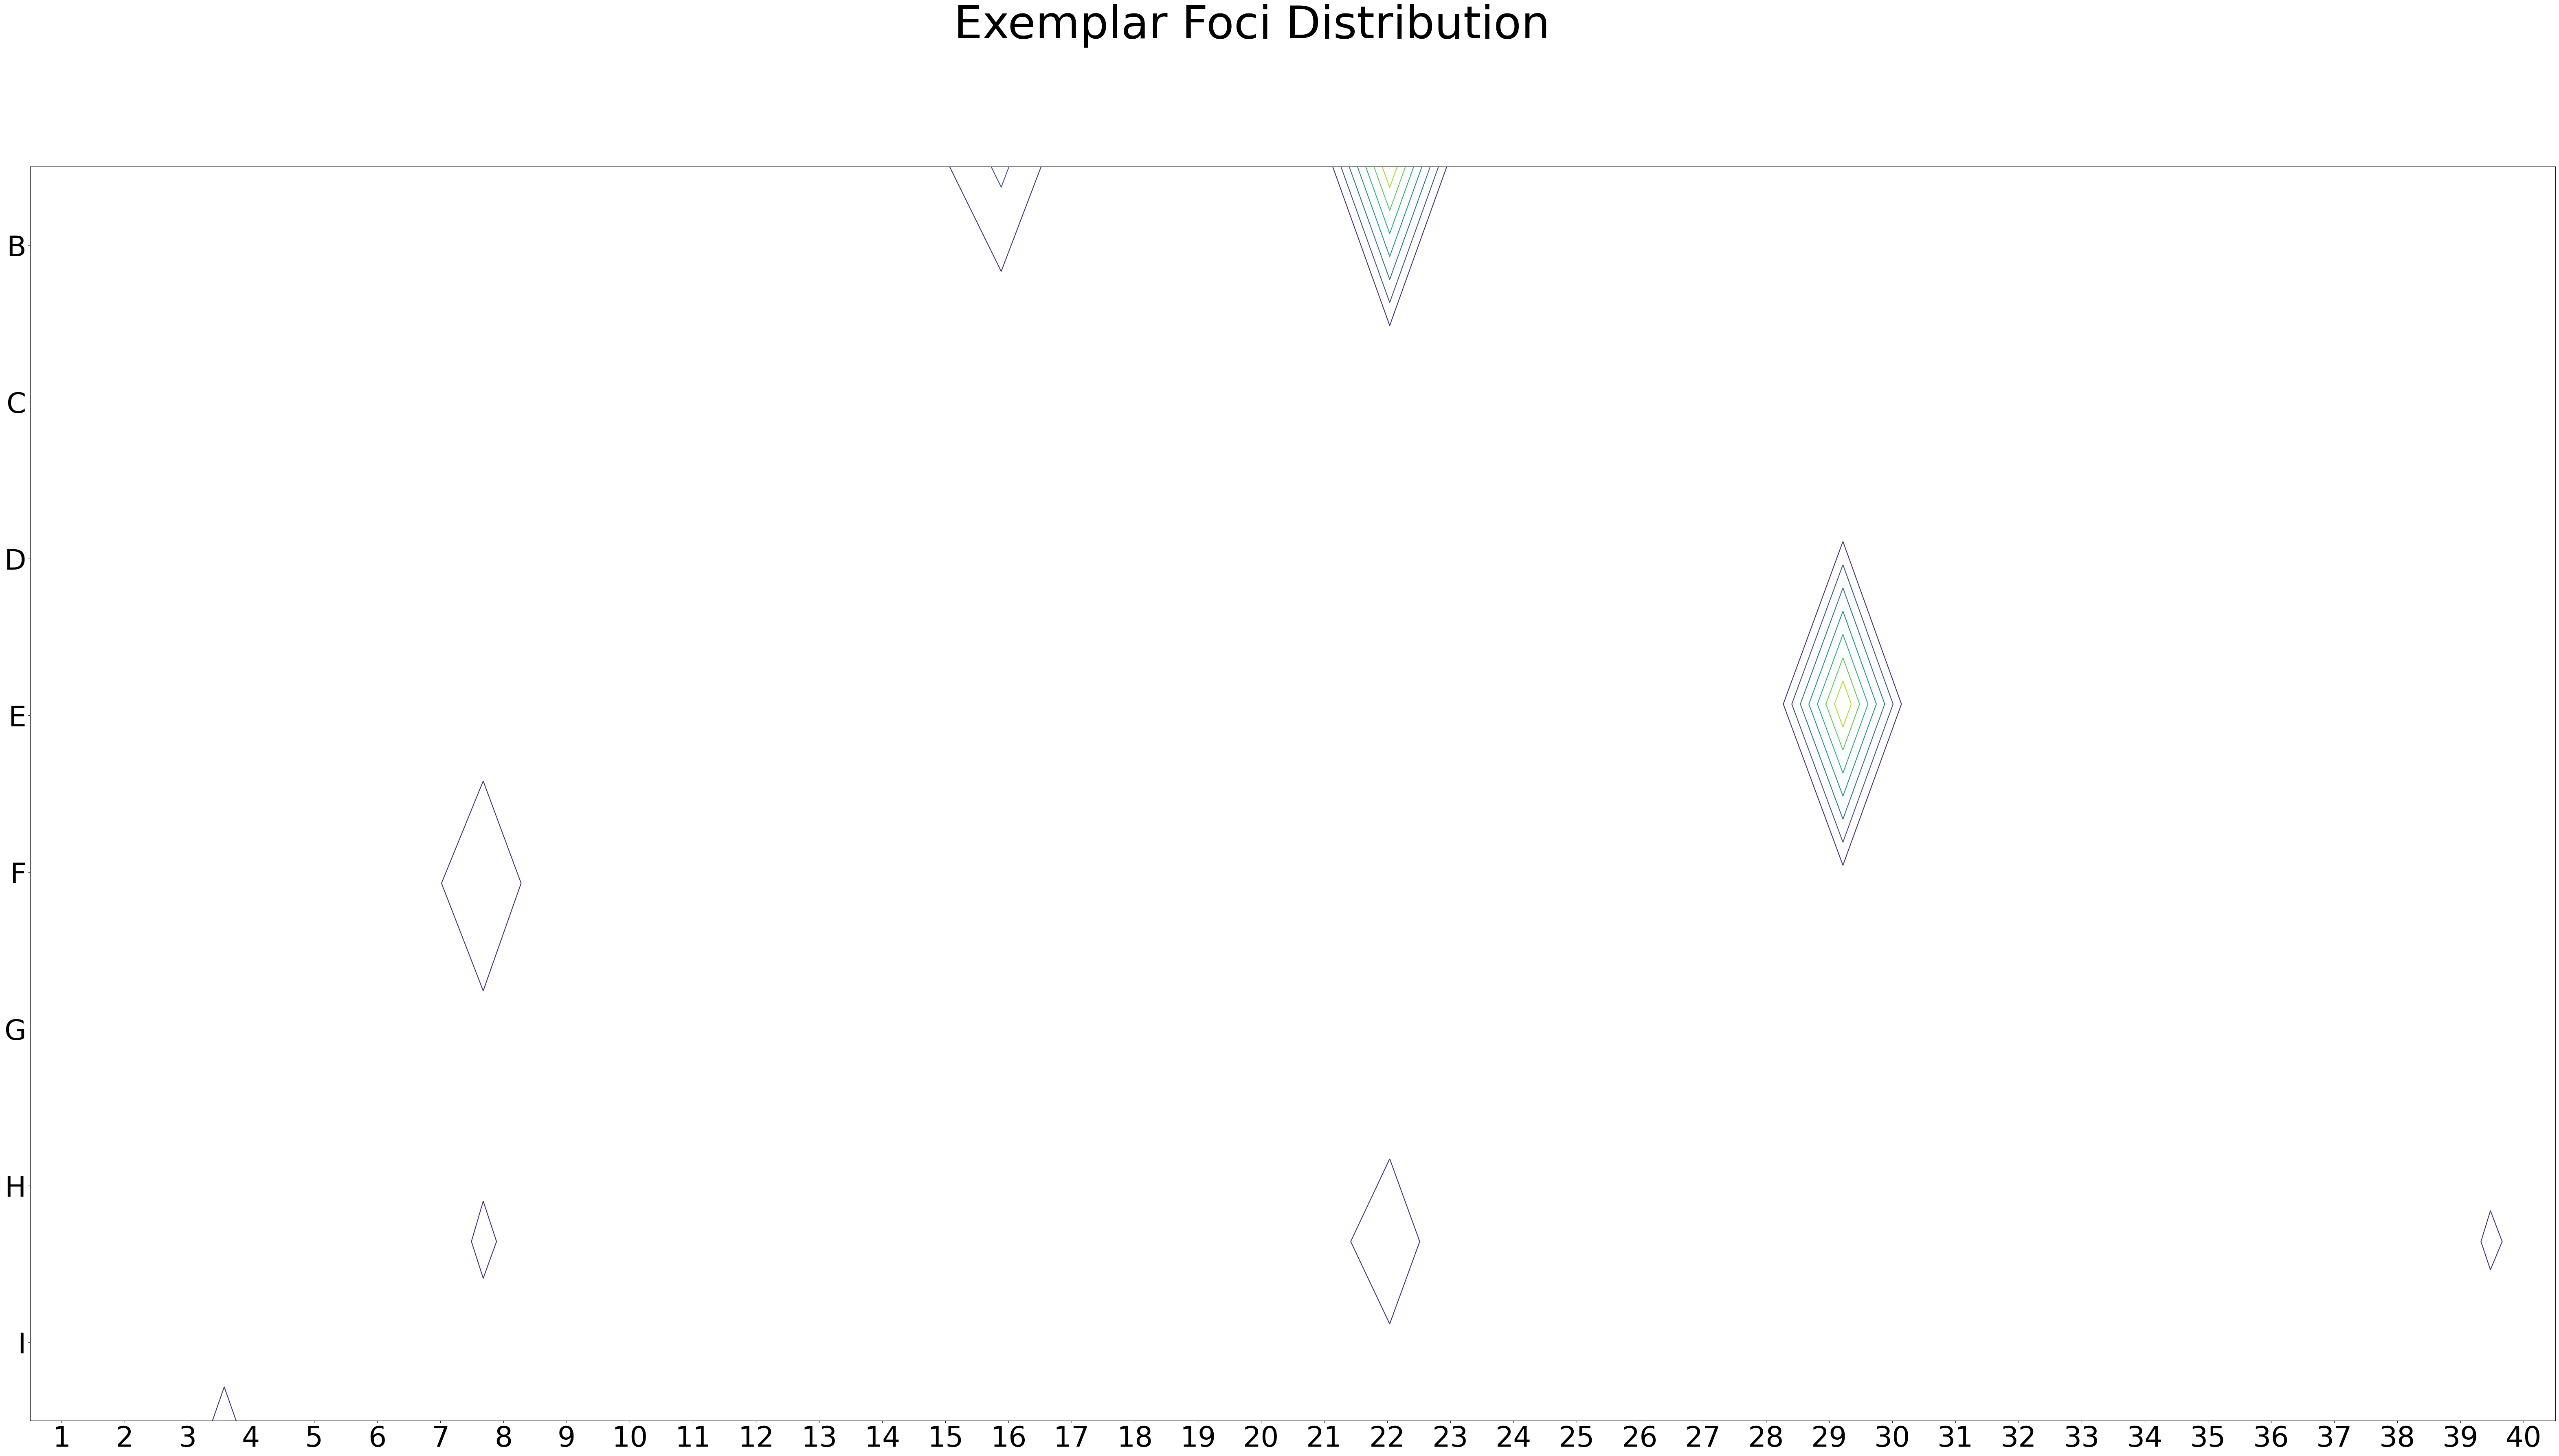

In [286]:
fig = plotValuesContour(map_array_to(indexCoord, exemplar_predicted), title='Exemplar Foci Distribution')

### Quantitative Analysis

In [269]:
def create_histogram(distribution, num_chips=330):
    histogram = np.zeros(num_chips)
    for chip_index in distribution:
        histogram[int(chip_index) - 1] = distribution[int(chip_index)]  # Assuming chip_index starts from 1
    return histogram

# Assuming we have 330 chips
hist_prototype = create_histogram(prototype_predicted, 330)
hist_wcs_focus = create_histogram(overallFociCount, 330)
hist_exemplar = create_histogram(exemplar_predicted, 330)

In [270]:
def qf_distance(H1, H2, M):
    diff = H1 - H2
    return np.sqrt(diff.T @ M @ diff)

In [271]:
def calculate_similarity_matrix(cielab_coords, c=0.001):
    num_chips = len(cielab_coords)
    M = np.zeros((num_chips, num_chips))

    for i in range(num_chips):
        for j in range(num_chips):
            # Calculate Euclidean distance between chip i and chip j
            distance = np.linalg.norm(cielab_coords[i] - cielab_coords[j])
            # Calculate similarity based on the distance
            M[i, j] = np.exp(-c * distance**2)

    return M

In [272]:
cielab_array = np.array([tuple(map(float, coords)) for coords in cielabCoord.values()])

M = calculate_similarity_matrix(cielab_array)

In [273]:
M.shape

(330, 330)

In [274]:
qf_prototype = qf_distance(hist_wcs_focus, hist_prototype, M)

In [275]:
qf_prototype

236.8804572749564

In [276]:
qf_exemplar = qf_distance(hist_wcs_focus, hist_exemplar, M)
qf_exemplar

5075.419601152889